# Psycho-Physical/Phsyiologiccal Interations

GLM: `target_TS ~ seed_TS + psy_context + seed_TS*psy_context`

seed_TS = NPC/parietal cortex?! 
-->parcel_N in Dorsal-Attention Net =  230, 275, 296, 297, 326 {from gradients/groupComp...02.ipynb} $$  $$
target_TS = rest ?! (expect to find differences in visual>?)


Maybe:
* https://dartbrains.org/content/Connectivity.html

In [1]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.utils.parcellation import reduce_by_labels
import numpy as np
import os.path as op
from numrisk.fmri_analysis.gradients.utils import cleanTS, get_glasser_parcels
from numrisk.fmri_analysis.gradients.utils_old import get_events_confounds
import seaborn as sns
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 

# Get Glasser parcellation and mask
mask, labeling = get_glasser_parcels(space = 'fsaverage5' )

In [ ]:
# debug 'get_events_confounds'
# ValueError: The following column must not contain nan values: duration
from utils_01 import get_cleanTS_run, get_events_confounds
subject = 2
sub = f'{int(subject):02d}'

run = 2
ts = get_cleanTS_run(sub, run=run, bids_folder=bids_folder)
dm = get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder)


In [2]:
# 
from utils_01 import get_cleanTS_run
subject = 2
sub = f'{int(subject):02d}'

DMs = []
TSs = []
for run in range(1, 7):
    try:
        dm = get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder)
        dm['run'] = run
        ts = get_cleanTS_run(sub, run=run, bids_folder=bids_folder)

        TSs.append(ts)
        DMs.append(dm)
    except:
        print(f'!!! ------ problems for run {run} (sub {sub} )')


dm = pd.concat(DMs) # 1128 timesteps = 188 x 6
dm.index.name = 'onset'
dm.set_index('run',append=True,inplace=True)

TSs = np.array(TSs)
TSs = TSs.transpose(1, 0, 2).reshape(TSs.shape[1], (TSs.shape[0]*TSs.shape[2]))
seed_ts = reduce_by_labels(TSs[mask], labeling[mask], axis=1, red_op='mean',dtype=float)

print(np.shape(seed_ts))
print(np.shape(dm))

A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
!!! ------ problems for run 2 (sub 02 )
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
!!! ------ problems for run 5 (sub 02 )
!!! ------ problems for run 6 (sub 02 )
(360, 564)
(564, 12)


In [18]:
# old way

subject = 1
sub = f'{int(subject):02d}'

clean_ts = cleanTS(sub, ses=1,bids_folder=bids_folder,space = 'fsaverage5') #does fsavTofsav5 if fsav5.gii does not exist
seed_ts = reduce_by_labels(clean_ts[mask], labeling[mask], axis=1, red_op='mean',dtype=float)

DMs = []
for run in range(1, 7):
    try:
        dm = get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder)
        dm['run'] = run
        DMs.append(dm)
    except:
        print(f'!!! ------ problems for run {run} (sub {sub} )')
# DMs = [get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder) for run in range(1, 7)]
    
dm = pd.concat(DMs) # 1128 timesteps = 188 x 6
dm.index.name = 'onset'
dm.set_index('run',append=True,inplace=True)

print(np.shape(seed_ts))
print(np.shape(dm))

sub-05, run-5 makes problems (prob. confounds ts not there) 
 skipping that run
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
A 'modulation' column was found in the given events data and is used.
Design matrix created to remove task effects. shape:
(188, 12)
!!! ------ problems for run 6 (sub 05 )
(360, 940)
(940, 12)


## verify that events-df (DM) is correct by identifying some visual-network parcel that correlates with stim presentation

In [29]:
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping

glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

vis2_indices = np.where(glasser_CAatlas_mapping['ca_network'] == 2)[0]
vis2_indices


array([  1,   2,   3,   4,   5,   6,  12,  15,  16,  17,  18,  19,  20,
        21,  22,  47,  48, 137, 151, 152, 153, 155, 156, 157, 158, 159,
       162, 181, 182, 183, 184, 185, 186, 192, 195, 196, 197, 198, 199,
       200, 201, 202, 227, 228, 317, 331, 332, 333, 335, 336, 337, 338,
       339, 342])

In [32]:
import statsmodels.api as sm
psy_context = 'stimulus1_int'
formula = 'seedTS ~ psy_context'

p_vals = []
betas = []
for parcel_n in vis2_indices:
    df_glm = pd.DataFrame(np.array([seed_ts[parcel_n], dm[psy_context]]).T, columns = ['seedTS','psy_context'])
    result = sm.formula.ols(formula=formula, data=df_glm).fit()
    p_vals.append(result.pvalues['psy_context'])
    betas.append(result.params['psy_context'])

p_vals = np.array(p_vals)
betas = np.array(betas)

336
336


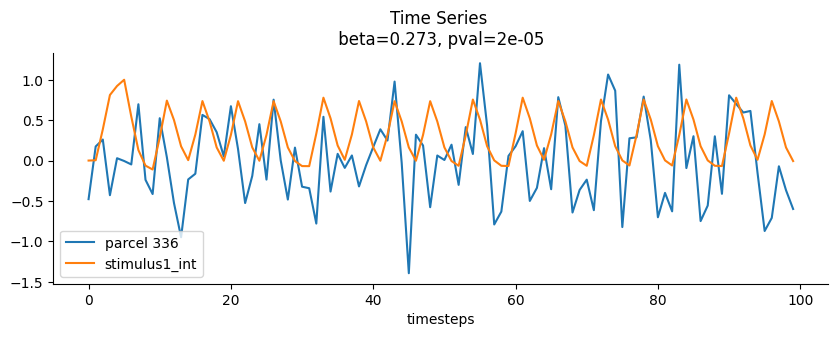

In [33]:
# parcel with strongest correlation 
print(vis2_indices[np.where(p_vals == np.min(p_vals))[0][0]])
print(vis2_indices[np.where(betas == np.max(betas))[0][0]])

top_cor_parcel = vis2_indices[np.where(p_vals == np.min(p_vals))[0][0]]
pval = np.round(np.min(p_vals),5)
coef = np.round(np.max(betas),3)

# correlation demonstration
n_timesteps = 100
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(range(n_timesteps), seed_ts[top_cor_parcel,:n_timesteps], label=f'parcel {top_cor_parcel}')
plt.plot(range(n_timesteps), dm[psy_context][:n_timesteps], label=psy_context)
plt.legend()
ax.set(title=f'Time Series \n beta={coef}, pval={pval} ', xlabel='timesteps')
sns.despine()   

# PPI

In [34]:
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping,get_glasser_parcels

glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from brainspace.utils.parcellation import map_to_labels
from numrisk.fmri_analysis.gradients.utils_02 import get_pval_colormap

pval_cmap = get_pval_colormap()
views = ['medial','lateral','dorsal','posterior']

from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

import nilearn.plotting as nplt


In [46]:
psy_context = 'stimulus2_int'
formula = 'targetTS ~ seedTS + psy_context + seedTS:psy_context'
seed_parcel = 275

seedTS = seed_ts[seed_parcel]
p_vals = {'seedTS' : [], 'psy_context' : [],'seedTS:psy_context':[]} #, 'distances':[]}
coef = {'seedTS' : [], 'psy_context' : [],'seedTS:psy_context':[]} #, 'distances':[]}

for parcel_n in range(360):
    df_glm = pd.DataFrame(np.array([seedTS, seed_ts[parcel_n], dm[psy_context]]).T, columns = ['seedTS','targetTS','psy_context'])
    result = sm.formula.ols(formula=formula, data=df_glm).fit()
    [p_vals[param].append(result.pvalues[param]) for param in p_vals.keys()]
    [coef[param].append(result.params[param]) for param in coef.keys()]


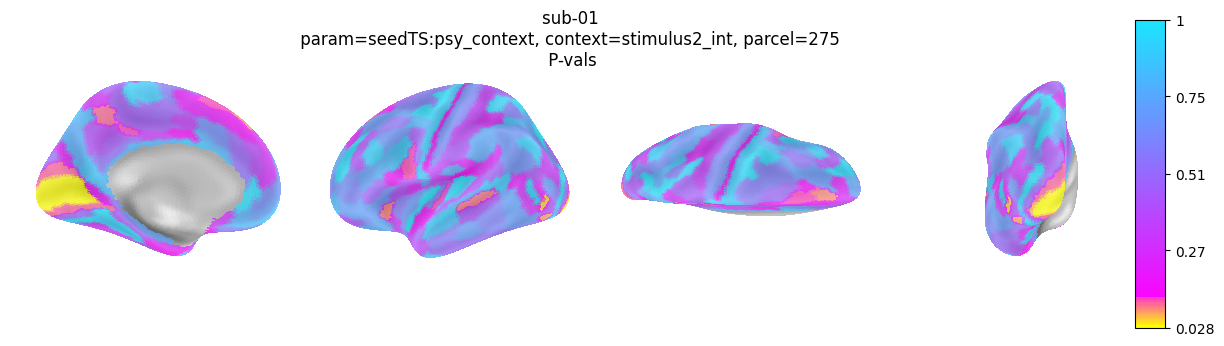

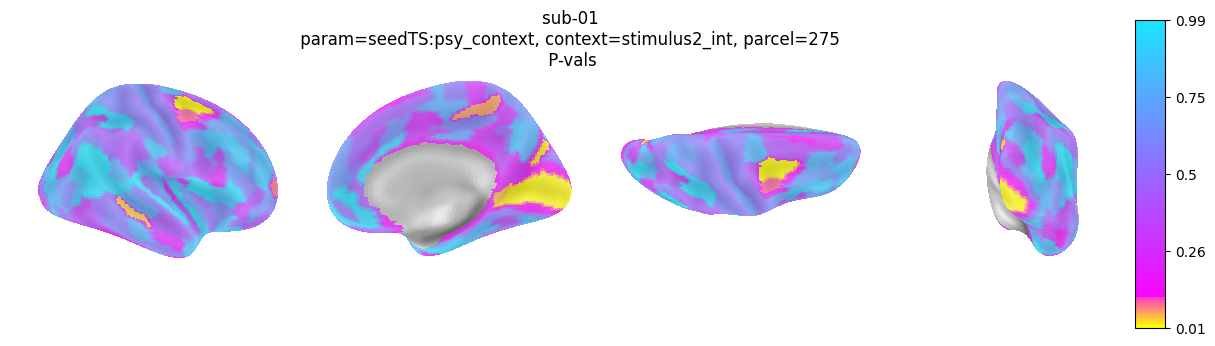

In [47]:
param = 'seedTS:psy_context'
#if resolution == 'parcel':
stats_fsav5 = map_to_labels(np.array(p_vals[param]), labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex

for i, hemi in enumerate(['L','R']):
    map = np.split(stats_fsav5,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, # infl_right # pial_right
                view= view,cmap=pval_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'sub-{sub} \n param={param}, context={psy_context}, parcel={seed_parcel}  \n P-vals ', y=0.7)

In [32]:
from nilearn.glm.first_level import FirstLevelModel

slice_time_ref = 0.5 # Slice timing correction in fMRIPrep is referenced to the middle slice by default, which leads to a time shift in the volume onsets by 0.5 TR (repetition time)

glm = FirstLevelModel(
    t_r=2.5,
    slice_time_ref=slice_time_ref,
    hrf_model="glover + derivative",
).fit(run_imgs=seed_ts, events=data.events)

1128

In [40]:
from nilearn.datasets import fetch_localizer_first_level

data = fetch_localizer_first_level()

data.events

'/home/ubuntu/nilearn_data/localizer_first_level/localizer_first_level/sub-12069_task-localizer_events.tsv'

In [45]:
df_events = pd.read_csv(data.events, sep='\t')
df_events

,trial_type,onset,duration
0,visual_computation,0.000000,1.0
1,visual_computation,2.400000,1.0
2,horizontal_checkerboard,8.700000,1.0
3,audio_right_hand_button_press,11.400000,1.0
4,sentence_listening,15.000000,1.0
...,...,...,...
75,sentence_listening,284.399994,1.0
76,sentence_reading,288.000000,1.0
77,visual_right_hand_button_press,291.000000,1.0
78,sentence_listening,293.399994,1.0
